In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: laavanjan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:25<00:00, 87.8MB/s]


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch.optim import Adam
import librosa
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_df = pd.read_csv('/content/quran-recitations-for-audio-classification/files_paths.csv')
data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset' + data_df['FilePath'].str[1:]
data_df.head()

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


In [4]:
 data_df['FilePath'].iloc[2]

'/content/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_401.wav'

In [5]:
print('Data shape:',data_df.shape)
print('Class Distribution:',data_df['Class'].value_counts())

Data shape: (6687, 2)
Class Distribution: Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


the dataset is not completely balaced but we can say it is kind of ok

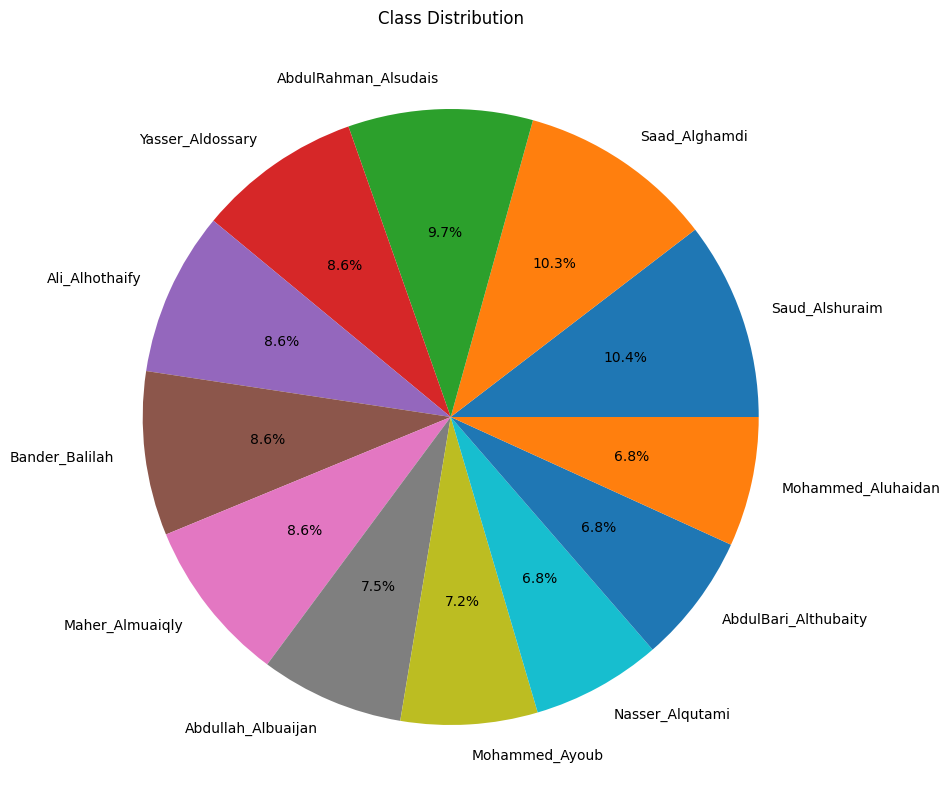

In [6]:
plt.figure(figsize=(10,10))
plt.pie(data_df['Class'].value_counts(), labels=data_df['Class'].value_counts().index,autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

The data distribution is not 100% balanced but it is some how accepatable
Training: 70%,
Validation: 15%,
Testing: 15%

In [7]:
train = data_df.sample(frac=0.7,random_state=7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5,random_state = 7)
test = test.drop(val.index)

print('Train shape:',train.shape)
print('Validation shape:',val.shape)
print('Test shape:',test.shape)

Train shape: (4681, 2)
Validation shape: (1003, 2)
Test shape: (1003, 2)


In [8]:
class CustomAudioDataset(Dataset):
  def __init__(self, dataframe):
    self.dataframe = dataframe
    # Encode labels
    le = LabelEncoder()
    self.labels = torch.Tensor(le.fit_transform(dataframe["Class"])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = (self.audios[idx]).unsqueeze(0).to(device)
    return audio, label

  def get_spectrogram(self, file_path):
    sr = 22050 # Set the sample rate of the audio file
    duration = 5 # Set the duration of the audio files

    # Set the size of the spectrogram images
    img_height = 128
    img_width = 256

    # Load the audio file
    signal, sr = librosa.load(file_path, sr=22050, duration=duration)

    # Compute the spectrogram
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    # Convert the spectrogram to dB scale
    spec_db = librosa.power_to_db(spec, ref=np.max)

    # Resize the spectrogram to the desired shape
    spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    return spec_resized

In [9]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [10]:
import os

print(os.path.exists("/content/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Ayoub/mAyoub_193.wav"))


True


In [11]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1) # First Convolution layer
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1) # Second Convolution layer
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1) # Third Convolution layer
    self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
    self.relu = nn.ReLU() # ReLU Activation function

    self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
    self.linear1 = nn.Linear((64 * 16 * 32), 4096) # Traditional Dense (Linear)
    self.linear2 = nn.Linear(4096, 1024) # Traditional Dense (Linear)
    self.linear4 = nn.Linear(1024, 512) # Traditional Dense (Linear)
    self.output = nn.Linear(512, len(data_df['Class'].unique())) # Output Linear Layer

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (16, (128, 256))
    x = self.pooling(x)# -> Outputs: (16, (64, 128))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x) # -> Outputs: (32, (64, 128))
    x = self.pooling(x) # -> Outputs: (32, (32, 64))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x) # -> Outputs: (64, (32, 64))
    x = self.pooling(x) # -> Outputs: (64, (16, 32))
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)


    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device


print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [14]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [16]:
total_loss_train_plot = [] # Empty list to be filled with train loss after each epoch
total_loss_validation_plot = [] # Empty list to be filled with validation loss after each epoch
total_acc_train_plot = [] # Empty list to be filled with train accuracy after each epoch
total_acc_validation_plot = [] # Empty list to be filled with validation accuracy after each epoch


for epoch in range(EPOCHS):
  start_time = time.time() # We use this to calculate the time of each epoch, it starts a counter once called
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  epoch_string = f"""
                  Epoch: {epoch+1}/{EPOCHS},
                  Train Loss: {round(total_loss_train/100, 4)},
                  Train Accuracy: {round((total_acc_train/train_dataset.__len__() * 100), 4)},
                  Validation Loss: {round(total_loss_val/100, 4)},
                  Validation Accuracy: {round((total_acc_val/val_dataset.__len__() * 100), 4)}
                  """
  print(epoch_string)
  print("="*30)



                  Epoch: 1/25, 
                  Train Loss: 23.0467, 
                  Train Accuracy: 11.4078, 
                  Validation Loss: 1.5619, 
                  Validation Accuracy: 11.5653
                  

                  Epoch: 2/25, 
                  Train Loss: 7.1278, 
                  Train Accuracy: 12.0914, 
                  Validation Loss: 1.5237, 
                  Validation Accuracy: 13.5593
                  

                  Epoch: 3/25, 
                  Train Loss: 7.0113, 
                  Train Accuracy: 14.3986, 
                  Validation Loss: 1.4966, 
                  Validation Accuracy: 17.1486
                  

                  Epoch: 4/25, 
                  Train Loss: 6.6475, 
                  Train Accuracy: 20.8502, 
                  Validation Loss: 1.3664, 
                  Validation Accuracy: 25.6231
                  

                  Epoch: 5/25, 
                  Train Loss: 5.6764, 
                  Train

In [17]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 88.43%


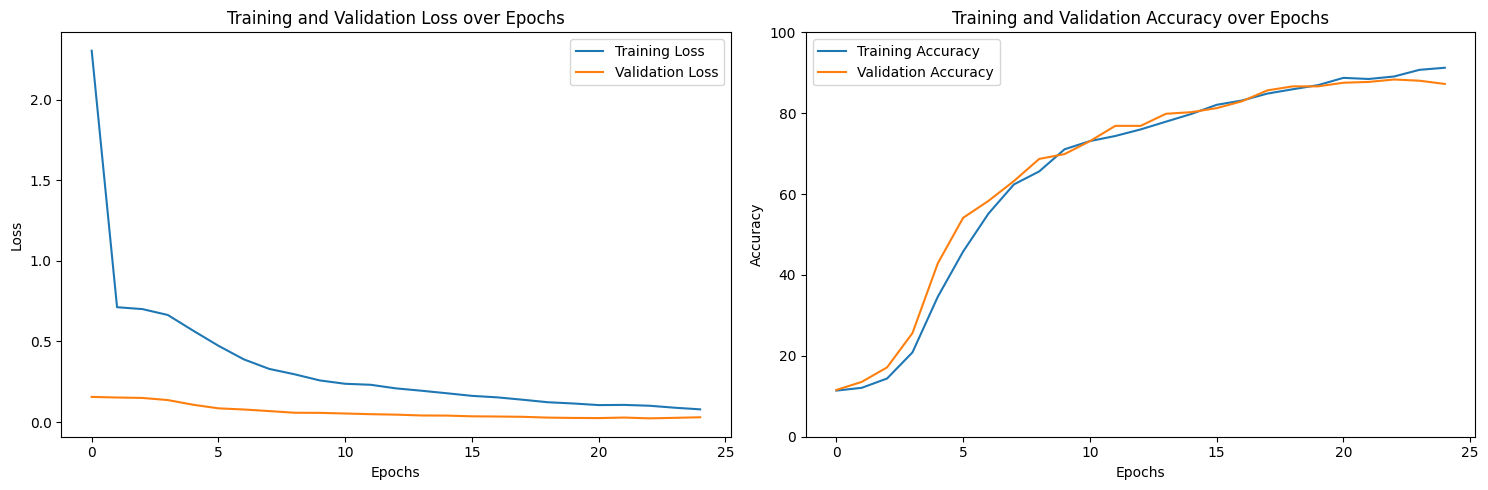

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

🔍 Left Plot: Training and Validation Loss
Training loss (blue): Decreases steadily — this is expected and good.

Validation loss (orange): Starts low and decreases a little, but then flattens out and even slightly increases toward the end.

➡️ This is a classic sign of overfitting:

The model keeps improving on the training data

But stops improving (or worsens) on validation data

🔍 Right Plot: Training and Validation Accuracy
Both training and validation accuracy increase over time — that’s good.

However, in the last few epochs:

Training accuracy continues to increase

Validation accuracy plateaus or dips slightly

➡️ This indicates the model is memorizing the training data more than generalizing to unseen data.

📌 Conclusion:
✅ Mild overfitting is occurring.
This is not drastic, but the validation metrics no longer improve — or slightly worsen — as training continues